In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import math

In [2]:
asciiLC = 'supernova1b_template.dat'
filterNames = ['u', 'g', 'r', 'i', 'z']
colors = {'u':'purple','g':'g','r':'r','i':'blue','z':'m'}
location_of_peak = np.arange(59700, 60000, 30)
height_of_peak = np.arange(17,21,1)

In [3]:
# Set the database and query
runName = 'minion_1016'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [50]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,1000), np.random.uniform(-60,-30,1000))
#slicer = slicers.UserPointsSlicer(0, -45)
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, 
    and five sigma depth for each ra and dec chosen"""
    
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        bdict = {key: bundle.metricValues[coord][key] for 
                 key in ['fieldRA', 'fieldDec', 'expMJD', 'filter', 'fiveSigmaDepth']}
        t = Table(bdict)
        t.rename_column('expMJD', 'day')
        t = t[t['filter'] != 'y']
        t.sort('day')
        listofDict.append(t)
    return listofDict

In [6]:
def read_lightcurve(asciifile, f):
    skip = 0
    if f == 'u':
        columns = (0,1,2)
        skip = 40
    elif f == 'g':
        columns = (3,4,5)
    elif f == 'r':
        columns = (6,7,8)
    elif f == 'i':
        columns = (9,10,11)
    elif f == 'z':
        columns = (12,13,14)
    else:
        pass
    #Reads asciifile - three columns (phase, magnitude, filter)
    lc = np.genfromtxt(asciifile, dtype=[('day', np.float), ('mag', np.float), ('error', np.float)],
                       skip_header = 1, skip_footer = skip, usecols = columns)

    return {f:lc}

In [7]:
def add_data_to_lc_table(asciiLC, template):
    '''This function returns a table with phase, magnitude, and filter for a light curve read
    in from an ascii file'''
    for f in filterNames:  
        curvedata = read_lightcurve(asciiLC, f)
        bdict = {key: curvedata[f][key] for key in ['day', 'mag', 'error']}
        t = Table(bdict)
        t['filter'] = f
        for row in range(len(t)):
            t['mag'][row] = -2.5*math.log10(t['mag'][row])
            template.add_row(t[row])
    template.sort('day')
    return template

In [8]:
def normalize_template(template):
    peaktable = peak_brightness(template)
    peakmag = peaktable['g'][1]
    template['mag'] -= peakmag
    return template

In [9]:
def peak_brightness(template):
    
    """This function returns a table of peak magnitude and the day it occurs 
    for each filter from the read in lightcurve"""
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(template['filter'] == f)
        maxmag = np.amin(template['mag'][fMatch])
        location = np.argmin(template['mag'][fMatch])
        maxday = template['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'mag']
    orderedPeak = peak[' ','u','g','r','i','z']
    return orderedPeak

In [10]:
def adjust_peak(template, peakday, peakmag):
    adjusted_template = template.copy()
    """This function finds the necessary adjustment needed to make the peak 
    of the red filter occur at the right place and adjusts all filters by that same ammount"""
    
    adjusted_template['day'] += peakday
    adjusted_template['mag'] += peakmag
    
    return adjusted_template

In [11]:
def adjust_opsim_table(opsim, adjusted_template):
    new_opsim = opsim.copy()
    new_opsim = new_opsim[new_opsim['day']< adjusted_template['day'].max()]
    new_opsim = new_opsim[new_opsim['day']> adjusted_template['day'].min()]
    return new_opsim

In [12]:
def interpolate_light_curve(adjusted_template, new_opsim):
    
    #for each filter interpolate the read in light curve to the days of the opsim in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_template['filter'] == f)
        lc[f] = np.interp(new_opsim['day'], adjusted_template['day'][fMatch], adjusted_template['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = new_opsim['day']
    lightcurve = lightcurve['day', 'u', 'g', 'r', 'i', 'z']
    return lightcurve

In [13]:
def resample_light_curve(lightcurve, new_opsim):
    
    """add to the opsim table a magnitude column where the magnitude is taken 
    from the index of the interpolated light curve where both the filter and day matched the opsim"""
    
    new_opsim['magnitude'] = 0.
    for row in range(len(new_opsim)):
        filterName = new_opsim['filter'][row]
        new_opsim['magnitude'][row] = lightcurve[filterName][row]
    return new_opsim

In [14]:
def calculate_error(new_opsim):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in opsim
    
    snr = 5.*10.**(-0.4*(new_opsim['magnitude'] - new_opsim['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    new_opsim['error'] = lc_err
    
    return new_opsim

In [15]:
def magnitude_distribution(new_opsim):
    new_opsim['magnitude'] = np.random.normal(new_opsim['magnitude'], new_opsim['error'])
    return new_opsim

In [16]:
def func_per_filter(f):
    def func(time, peak_mag, peak_time):
        new_template = template.copy()
        new_template['mag'] += peak_mag
        new_template['day'] += peak_time
        fMatch = np.where(new_template['filter'] == f)
        model = np.interp(time, new_template['day'][fMatch], new_template['mag'][fMatch],left=99,right=99)
        return model
    return func

In [17]:
def fit_curve(opsim_fmatch2, f):
    initial_parameters = [opsim_fmatch2['magnitude'].min(), 
                          opsim_fmatch2['day'][opsim_fmatch2['magnitude'].argmin()]]
    popt, pcov = optimize.curve_fit(func_per_filter(f), opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch2['error'])
    return popt

In [18]:
def func2(x, a, b, c, x0):
    return a*(x-x0)**2 + b*(x-x0) + c

In [19]:
def fit_curve2(opsim_fmatch, template_fmatch2):
    opsim_fmatch = opsim_fmatch[opsim_fmatch['day'] <= template_fmatch2['day'].max()]
    peak_day = opsim_fmatch['day'][opsim_fmatch['magnitude'].argmin()]
    peak_mag = opsim_fmatch['magnitude'].min()
    x_min = opsim_fmatch['day'].min()
    y_min = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmin()]
    x_max = opsim_fmatch['day'].max()
    y_max = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmax()]
    if x_min != peak_day:
        a = (y_min - peak_mag) / (x_min - peak_day)**2
    else:
        a = (y_max - peak_mag) / (x_max - peak_day)**2
    initial_parameters = [a, 0, peak_mag, peak_day]
    popt, pcov = optimize.curve_fit(func2, opsim_fmatch['day'], opsim_fmatch['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch['error'])
    return popt

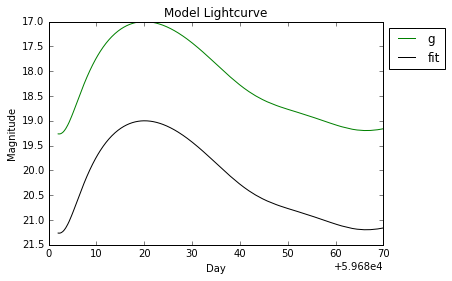

In [20]:
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
template = normalize_template(template)
peakday = 59700
peakmag = 17
adjusted_template = adjust_peak(template, peakday, peakmag)

model_per_filter = func_per_filter('g')
f = 'g'
filter_match = np.where(adjusted_template['filter'] == f)
plt.errorbar(adjusted_template['day'][filter_match], adjusted_template['mag'][filter_match], 
             color=colors[f], label = f)
plt.errorbar(adjusted_template['day'][filter_match], model_per_filter(adjusted_template['day'][filter_match], 19, 59700), 
             color='black', label = 'fit')
plt.ylim(plt.ylim()[::-1])
plt.title('Model Lightcurve')
plt.xlabel('Day')
plt.ylabel('Magnitude')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))


In [20]:
def create_curve(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt):
    plt.plot(xdata, func_per_filter(f)(xdata, *popt), 'black' , label='fit')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [21]:
def create_curve2(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt2):
    plt.plot(xdata, func2(xdata, *popt2), 'teal', label = 'poly')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [22]:
def resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt, popt2):
    
    peak_magnitude_difference_shift = template_fmatch2['mag'].min() - func_per_filter(f)(xdata, *popt).min()
    
    peak_magnitude_difference_poly = template_fmatch2['mag'].min() - func2(xdata, *popt2).min()

    return [ra, dec, f, peak_magnitude_difference_shift, peak_magnitude_difference_poly]

In [23]:
def resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2):

    actual_peak_day = template_fmatch2['day'][template_fmatch2['mag'].argmin()]
    
    fitted_peak_day_shift = func_per_filter(f)(xdata, *popt).argmin() + xdata.min()
    peak_day_difference_shift = actual_peak_day - fitted_peak_day_shift
    
    fitted_peak_day_poly = func2(xdata, *popt2).argmin() + xdata.min()
    peak_day_difference_poly = actual_peak_day - fitted_peak_day_poly
    
    return [ra, dec, f, peak_day_difference_shift, peak_day_difference_poly]

In [24]:
def create_peak_difference_table(peak):

    peak_difference = Table(names=('ra', 'dec', 'filter', peak + ' 1', peak + ' 2'), 
                                dtype=('float', 'float', 'string', 'float', 'float'))
    return peak_difference

In [51]:
survey = createdict_for_mjd_filter_depth(bundle)

In [52]:
peak1 = 'peak magnitude difference'
peak2 = 'peak day difference'
percent_table = Table(names=('ra', 'dec', 'percent template', 'percent polynomial'), 
                                dtype=('float', 'float', 'float', 'float'))
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)
peak_mag_difference_template = create_peak_difference_table(peak1)
peak_day_difference_template = create_peak_difference_table(peak2)
peak_mag_difference_poly = create_peak_difference_table(peak1)
peak_day_difference_poly = create_peak_difference_table(peak2)
strong_template = 0
strong_polynomial = 0
weak = 0
bad_fit_template = 0
bad_fit_polynomial = 0
unobserved = 0
for coord in range(len(bundle.metricValues)):
    enough_template = 0.
    not_enough_template = 0.
    enough_poly = 0.
    not_enough_poly = 0.
    opsim = survey[coord]
    ra = np.degrees(opsim['fieldRA'][0])
    dec = np.degrees(opsim['fieldDec'][0])
    for f in filterNames:
        for peakday in location_of_peak:
            for peakmag in height_of_peak:
                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)
                if len(new_opsim) == 0:
                    unobserved += 1
                    not_enough_template += 1
                    not_enough_poly += 1
                else:
                    lightcurve = interpolate_light_curve(adjusted_template, new_opsim)
                    new_opsim = resample_light_curve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])
                    if len(np.unique(opsim_fmatch['day'])) >= 4:
                        fMatch2 = np.where(new_opsim['filter'] == f)
                        opsim_fmatch2 = new_opsim[fMatch2]
                        fMatch3 = np.where(template['filter'] == f)
                        template_fmatch = template[fMatch3]
                        fMatch4 = np.where(adjusted_template['filter'] == f)
                        template_fmatch2 = adjusted_template[fMatch4]
                        xdata = np.arange(template_fmatch2['day'].min(), template_fmatch2['day'].max(), 1)
                        popt = fit_curve(opsim_fmatch2, f)
                        popt2 = fit_curve2(opsim_fmatch, template_fmatch2)
                        peak_day_list = resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        peak_mag_list = resampled_peak_magnitude(ra, dec, f, template_fmatch2, 
                                                                 xdata, popt, popt2)
                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 5:
                            #create_curve(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt)
                            bad_fit_template += 1
                            not_enough_template += 1
                        else:
                            peak_mag_difference_template.add_row(peak_mag_list)
                            peak_day_difference_template.add_row(peak_day_list)
                            strong_template += 1
                            enough_template += 1
                        if abs(peak_mag_list[4]) > 0.5 or abs(peak_day_list[4]) > 5:
                            #create_curve2(f, ra, dec, peakday, peakmag, 
                            #    opsim_fmatch2, template_fmatch2, xdata, popt2)
                            bad_fit_polynomial += 1
                            not_enough_poly += 1
                        else:
                            peak_mag_difference_poly.add_row(peak_mag_list)
                            peak_day_difference_poly.add_row(peak_day_list)
                            strong_polynomial += 1
                            enough_poly += 1
                    else:
                        weak += 1
                        not_enough_template += 1
                        not_enough_poly += 1
                        
    percent_with_enough_template = enough_template/(enough_template + not_enough_template)*100
    percent_with_enough_poly = enough_poly/(enough_poly + not_enough_poly)*100
    print(ra, dec, percent_with_enough_template, percent_with_enough_poly)
    percent_table.add_row([ra, dec, percent_with_enough_template, percent_with_enough_poly])

(278.26348492414883, -42.489862537547694, 0.0, 0.0)
(52.36444636195035, -46.879464093383469, 2.0, 2.0)
(350.26353869990953, -42.489862537547694, 0.0, 0.0)
(334.93411018696389, -59.242231734700752, 0.0, 0.0)
(73.657506085515195, -31.706739537406087, 0.0, 0.0)
(129.9039133968154, -50.212244996100438, 4.0, 4.0)
(205.79160040409781, -34.120209657835652, 0.0, 0.0)
(62.566246383152226, -50.583407055786189, 0.0, 0.0)
(247.88743986593403, -46.963173227252085, 4.0, 4.0)
(57.903859621054664, -50.212187700320932, 0.0, 0.0)
(21.208319265664986, -41.228209472669619, 0.0, 0.0)
(154.94617974859833, -55.697227264667326, 2.0, 2.0)
(48.63775697508094, -32.459090418192368, 0.0, 0.0)
(160.43339655256619, -44.610379337326869, 0.0, 0.0)
(305.4181893707995, -41.767362757887724, 2.0, 2.0)
(199.6968764499527, -55.221385815811175, 0.0, 0.0)
(227.52698354550364, -31.197781127991377, 0.0, 0.0)
(231.80629072577673, -36.402587034739291, 0.0, 0.0)
(163.63560037377286, -46.879464093383469, 0.0, 0.0)
(35.9999695921008

(205.00458557670612, -47.819229468957047, 0.0, 0.0)
(176.50618050891461, -35.901306259779332, 0.0, 0.0)
(237.52429492962332, -54.543232969494333, 2.0, 2.0)
(241.89057710319727, -56.451869976634136, 2.0, 2.0)
(202.40656575046492, -42.18459062430199, 0.0, 0.0)
(338.89210263572761, -29.966265643137184, 0.0, 0.0)
(353.17531021476435, -34.332433225152116, 0.0, 0.0)
(199.12718451425414, -33.447958276808656, 0.0, 0.0)
(44.386983093005362, -48.06657534911502, 2.0, 2.0)
(248.50617698889582, -35.901306259779332, 6.0, 6.0)
(302.09618007463104, -50.212187700320932, 0.0, 0.0)
(174.71219235658046, -58.173149784766146, 0.0, 0.0)
(11.526994105559954, -31.197781127991377, 0.0, 0.0)
(298.99544707894199, -47.819229468957047, 2.0, 2.0)
(120.63775345506215, -32.459147713971888, 0.0, 0.0)
(35.999969592100861, -31.82992546335921, 0.0, 0.0)
(205.79160040409781, -34.120209657835652, 0.0, 0.0)
(223.40655756182034, -39.869210878398825, 0.0, 0.0)
(124.36444284193158, -46.879464093383469, 2.0, 2.0)
(76.72781502228

(133.79154662833707, -34.120152362056139, 4.0, 4.0)
(62.263495484205094, -42.489805241768181, 0.0, 0.0)
(320.07536650271823, -44.182838230600254, 0.0, 0.0)
(298.20843225155033, -34.120152362056139, 0.0, 0.0)
(284.29088633736603, -40.00614779143509, 0.0, 0.0)
(342.58183624481103, -41.767420053667244, 0.0, 0.0)
(180.00001984784282, -31.829982759138726, 0.0, 0.0)
(272.19374192987135, -36.402587034739291, 6.0, 6.0)
(215.9999894399437, -56.071139521769702, 2.0, 2.0)
(222.61272453666658, -48.075341603380522, 0.0, 0.0)
(296.26341242441976, -45.302798832742475, 0.0, 0.0)
(125.6635673466112, -38.889223865607065, 0.0, 0.0)
(42.333616946815518, -31.161856674236677, 0.0, 0.0)
(272.65938472997419, -47.424461548111914, 2.0, 2.0)
(180.00001984784282, -54.054385378688714, 0.0, 0.0)
(265.56313054994041, -51.758314310481452, 2.0, 2.0)
(73.657506085515195, -31.706739537406087, 0.0, 0.0)
(159.34070874147218, -47.424461548111914, 0.0, 0.0)
(5.8532795392769774, -42.689710216489324, 0.0, 0.0)
(127.5667039589

(98.570169384039488, -53.656122415293282, 0.0, 0.0)
(337.38860408552483, -35.441622220745877, 0.0, 0.0)
(235.63553955797457, -46.879464093383469, 2.0, 2.0)
(92.429551510504396, -57.316577881045568, 0.0, 0.0)
(56.659337994251004, -47.424461548111914, 0.0, 0.0)
(169.06592246868425, -59.242231734700752, 2.0, 2.0)
(312.96513215248319, -40.550572288368393, 2.0, 2.0)
(107.99996607208209, -51.24270959064323, 0.0, 0.0)
(174.71219235658046, -58.173149784766146, 0.0, 0.0)
(311.20701115812432, -48.966520157927008, 4.0, 4.0)
(9.7364436999966184, -42.489862537547694, 0.0, 0.0)
(324.00001280780532, -54.054385378688714, 2.0, 2.0)
(184.90780443359495, -55.362963686988003, 0.0, 0.0)
(305.4181893707995, -41.767362757887724, 0.0, 0.0)
(35.999969592100861, -31.82992546335921, 0.0, 0.0)
(248.37972520351045, -38.654139282264886, 6.0, 6.0)
(16.303112989990982, -55.221385815811175, 0.0, 0.0)
(23.362239504900291, -32.459147713971888, 0.0, 0.0)
(281.38725082320201, -48.075284307601017, 2.0, 2.0)
(86.75417536661

(343.69692670569469, -55.221385815811175, 2.0, 2.0)
(220.13800522793753, -45.46952955112554, 0.0, 0.0)
(256.90780091357618, -55.362963686988003, 2.0, 2.0)
(205.05385994708737, -55.697227264667326, 0.0, 0.0)
(327.7622255779728, -41.413561319394439, 0.0, 0.0)
(25.065872212942281, -59.242231734700752, 0.0, 0.0)
(186.33355261099845, -31.161913970016187, 0.0, 0.0)
(7.6221721401843681, -53.306045202468347, 2.0, 2.0)
(245.28454989843425, -34.079128583924778, 2.0, 2.0)
(309.52434870538406, -54.543175673714821, 2.0, 2.0)
(117.46431211517108, -31.850380056645385, 6.0, 6.0)
(229.56023887308439, -33.824735322886688, 2.0, 2.0)
(107.99996607208209, -45.649953960812233, 0.0, 0.0)
(83.081745082945019, -39.639111027874286, 0.0, 0.0)
(295.62227265166831, -53.306045202468347, 0.0, 0.0)
(14.754178886634316, -57.958061428474046, 2.0, 2.0)
(347.65686721096188, -36.750773486840295, 0.0, 0.0)
(262.10939825667134, -56.451869976634136, 0.0, 0.0)
(308.42959824622761, -57.316635176825088, 0.0, 0.0)
(96.4448970345

(316.69079021532139, -39.70694923081777, 2.0, 2.0)
(74.983960677022552, -58.589231735590154, 0.0, 0.0)
(192.79296420174435, -48.96657745370652, 0.0, 0.0)
(217.65761363703669, -31.706739537406087, 0.0, 0.0)
(324.00001280780532, -40.103665208166355, 0.0, 0.0)
(18.694123164851423, -49.677331598566312, 2.0, 2.0)
(107.99996607208209, -37.345446382406571, 2.0, 2.0)
(153.43374305679146, -50.583407055786189, 0.0, 0.0)
(358.2251883337089, -37.272566150865934, 0.0, 0.0)
(300.34315840464876, -36.750830782619801, 0.0, 0.0)
(132.47305615018203, -31.197781127991377, 2.0, 2.0)
(192.79296420174435, -48.96657745370652, 0.0, 0.0)
(54.581793029106642, -41.767362757887724, 2.0, 2.0)
(297.43379331253345, -50.583407055786189, 0.0, 0.0)
(21.208319265664986, -41.228209472669619, 2.0, 2.0)
(165.52424115386256, -54.543232969494333, 0.0, 0.0)
(67.272120641900216, -50.801245609494927, 0.0, 0.0)
(82.995457638998317, -47.819229468957047, 0.0, 0.0)
(191.55520347692323, -43.36654525987737, 0.0, 0.0)
(70.2251451180044

(352.59347157380904, -39.869096286839792, 0.0, 0.0)
(262.54381485693949, -37.709217286535129, 8.0, 8.0)
(158.75411455081726, -57.958061428474046, 2.0, 2.0)
(133.05380617132661, -55.697227264667326, 0.0, 0.0)
(18.694123164851423, -49.677331598566312, 2.0, 2.0)
(222.82466162508547, -34.332490520931628, 4.0, 4.0)
(88.433285481025933, -44.610379337326869, 0.0, 0.0)
(264.63774641502465, -32.459147713971888, 6.0, 6.0)
(319.09222822205322, -55.362963686988003, 0.0, 0.0)
(237.52429492962332, -54.543232969494333, 2.0, 2.0)
(271.56669691888021, -44.610379337326869, 0.0, 0.0)
(120.63775345506215, -32.459147713971888, 2.0, 2.0)
(305.4181893707995, -41.767362757887724, 0.0, 0.0)
(15.340715781509738, -47.424461548111914, 0.0, 0.0)
(319.88737905013573, -46.963173227252085, 0.0, 0.0)
(123.53818040557343, -44.064866220582815, 0.0, 0.0)
(168.21725738253647, -29.40757449710512, 0.0, 0.0)
(140.58166945843246, -34.460431996584333, 4.0, 4.0)
(73.657506085515195, -31.706739537406087, 0.0, 0.0)
(273.273423599

In [53]:
print percent_table
print(np.average(percent_table['percent template']))
print(np.average(percent_table['percent polynomial']))
                    
print('weak = %d' %(weak))
print('unobserved = %d' %(unobserved))
print('strong template = %d' %(strong_template))
print('weak template = %d' %(bad_fit_template))
print('strong poly = %d' %(strong_polynomial))
print('weak poly = %d' %(bad_fit_polynomial))

      ra           dec       percent template percent polynomial
------------- -------------- ---------------- ------------------
278.263484924 -42.4898625375              0.0                0.0
 52.364446362 -46.8794640934              2.0                2.0
  350.2635387 -42.4898625375              0.0                0.0
334.934110187 -59.2422317347              0.0                0.0
73.6575060855 -31.7067395374              0.0                0.0
129.903913397 -50.2122449961              4.0                4.0
205.791600404 -34.1202096578              0.0                0.0
62.5662463832 -50.5834070558              0.0                0.0
247.887439866 -46.9631732273              4.0                4.0
57.9038596211 -50.2121877003              0.0                0.0
          ...            ...              ...                ...
151.406561082 -39.8691535826              0.0                0.0
 165.20825493 -41.2282094727              0.0                0.0
323.999955512  -42.871223

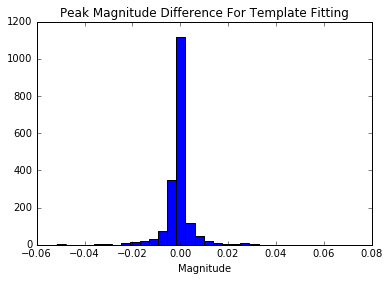

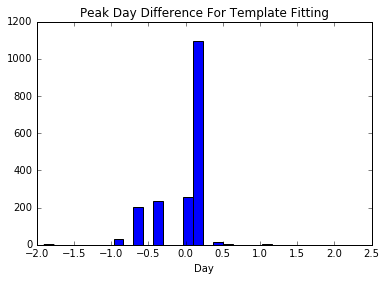

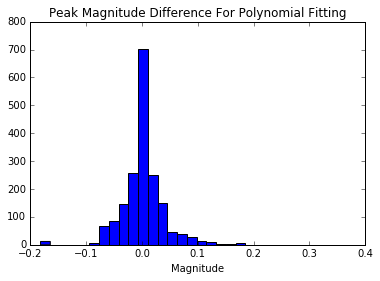

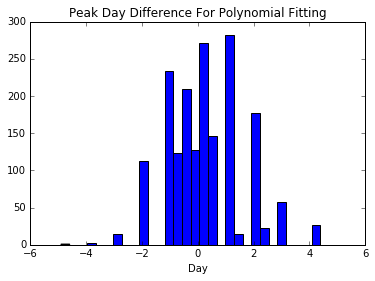

In [54]:
plt.figure()
plt.hist(peak_mag_difference_template['peak magnitude difference 1'], bins = 30)
plt.title('Peak Magnitude Difference For Template Fitting')
plt.xlabel('Magnitude')
plt.figure()
plt.hist(peak_day_difference_template['peak day difference 1'], bins = 30)
plt.title('Peak Day Difference For Template Fitting')
plt.xlabel('Day')
plt.figure()
plt.hist(peak_mag_difference_poly['peak magnitude difference 2'], bins = 30)
plt.title('Peak Magnitude Difference For Polynomial Fitting')
plt.xlabel('Magnitude')
plt.figure()
plt.hist(peak_day_difference_poly['peak day difference 2'], bins = 30)
plt.title('Peak Day Difference For Polynomial Fitting')
plt.xlabel('Day')